# Initialize constants

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# These measurements are for 10-46 guage steel guitar strings tuned on E-standard for a 25 1/2" scale length guitar from strings 1-6 (E, B, G, D, A, E)
# For example, D'Addario Regular Light Electric Guitar Strings EXL110 (https://www.daddario.com/products/guitar/electric-guitar/xl-nickel/exl110-nickel-wound-regular-light-10-46/)
# Arrays of tension while string is on guitar, according to (https://www.wirestrungharp.com/material/strings/table_3_wound_strings/#information)
TENSIONS_LBS = np.array([21.0, 21.0, 35.15, 35.87, 32.77, 27.75])
TENSIONS_N = (TENSIONS_LBS * 1.06) * 4.44822
# Mass per unit length array, in g/m according to (https://www.wirestrungharp.com/material/strings/table_3_wound_strings/#information)
MU = [1.45, 1.45, 2.44, 4.53, 7.46, 11.34]
# Scale length, in cm
SCALE_LENGTH = 25.5 * 2.54
# Center of the active length, cm
ACTIVE_CENTER = 55.6825
# Wave speed
c = np.sqrt(TENSIONS_N / MU)

print(1 / (2 * SCALE_LENGTH) * c)

[0.06379223 0.06379223 0.06362238 0.04716923 0.03513266 0.02622208]


# Solve the wave equation

<IPython.core.display.Javascript object>


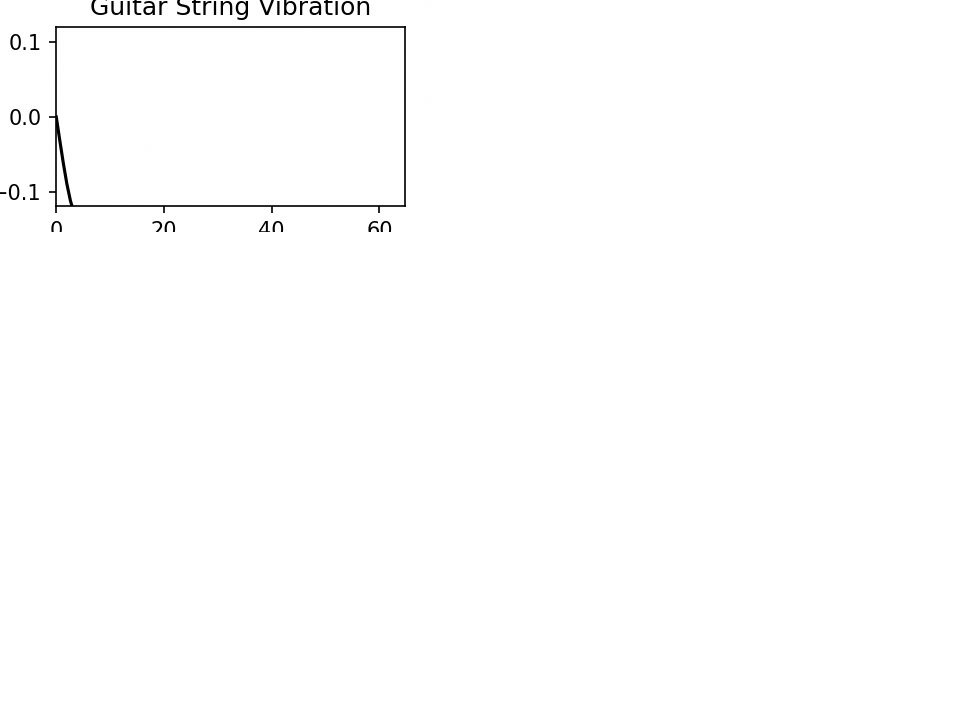

Frequency: 0.0 Hz


<IPython.core.display.Javascript object>


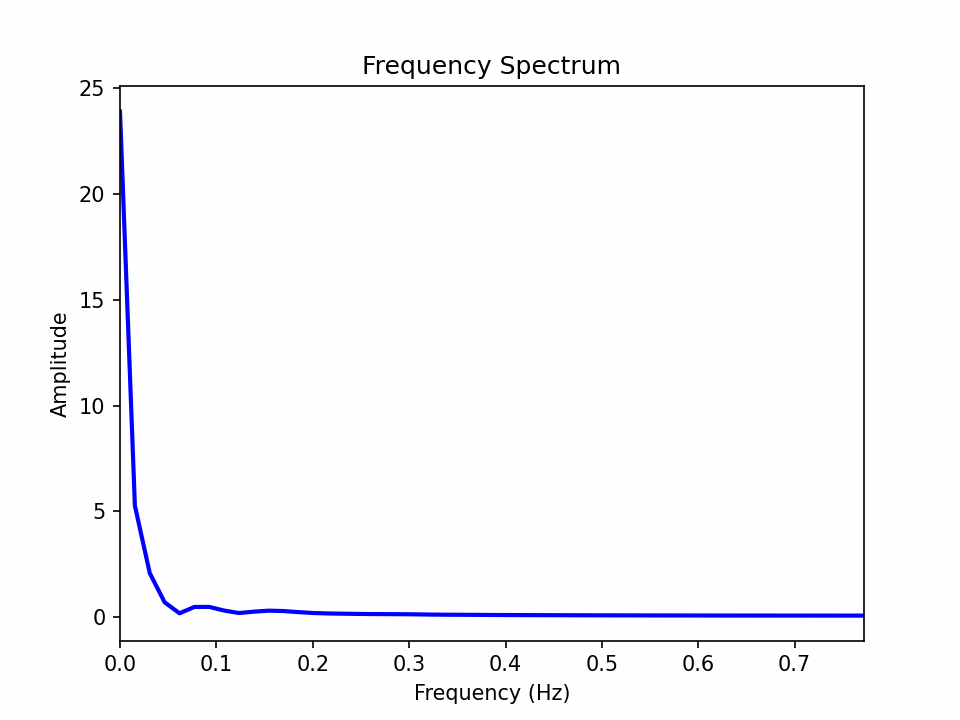

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ImageMagickWriter  
%matplotlib notebook

L = SCALE_LENGTH  # Length of the string
N = 100  # Number of grid points
T = 30  # Total time
dt = 0.01  # Time step
dx = L / N  # Grid spacing
string = 5 # temporary index
pluck = round(N * ACTIVE_CENTER / SCALE_LENGTH)

# Initial conditions
x = np.linspace(0, L, N)  # Grid points
u = np.zeros(N, float)  # Initial displacement
u[pluck] = 0.3  # Pluck the string
for i in range(0, pluck):
    u[i] = 0.3 / pluck * i
for i in range(pluck + 1, N):
    u[i] = -0.3 / (N - 1 - pluck) * i + 2.15611510791 
v = np.zeros(N, float)  # Initial velocity

# Function to update the wave at each time step
def update_wave(frame):
    global u, v
    u[1:-1] += v[1:-1] * dt + 0.5 * c[string]**2 * (u[:-2] - 2 * u[1:-1] + u[2:]) * dt**2 / dx**2
    v[1:-1] += 0.5 * c[string]**2 * (u[:-2] - 2 * u[1:-1] + u[2:]) * dt / dx**2
    line.set_ydata(u)
    return line,

# Create figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, L)
ax.set_ylim(-0.12, 0.12)
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Displacement (cm)')
ax.set_title('Guitar String Vibration')

# Create initial plot
line, = ax.plot(x, u, 'k-')

print("Frequency: {} Hz".format(frequency_hz))

# Create animation
anim = FuncAnimation(fig, update_wave, frames=int(T/dt), interval=5, blit=True)

# Save the animation
anim.save('animation0-12.mp4')

# Perform Fourier transform
freqs = np.fft.rfftfreq(N, d=dx)
u_fft = np.fft.rfft(u)

# Plot frequency spectrum
fig, ax = plt.subplots()
ax.plot(freqs, np.abs(u_fft), 'b', lw=2)
ax.set_xlim(0, max(freqs))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency Spectrum')
plt.show()